In [1]:
%pip uninstall -y transformers

Found existing installation: transformers 4.51.3
Uninstalling transformers-4.51.3:
  Successfully uninstalled transformers-4.51.3


In [2]:
#!pip install -U transformers

In [3]:
!pip install --upgrade --no-cache-dir transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 75.1 MB/s eta 0:00:00


In [4]:
%pip install datasets

In [5]:
%pip install evaluate

In [6]:
!pip install scikit-learn

In [7]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split

from datasets import Dataset, DatasetDict
import evaluate
from google.colab import files

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
#uploaded = files.upload()
df = pd.read_csv('merged.csv')

Create sentiment labels from review stars

In [9]:
def get_sentiment_label(star_rating):
    if star_rating >= 4:
        return 2  # Positive
    elif star_rating == 3:
        return 1  # Neutral
    else:
        return 0  # Negative

df['label'] = df['stars.y'].apply(get_sentiment_label)

In [10]:
df = df[['name','text', 'label']]

In [11]:
#split 80/10/10
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

In [12]:
dataset_dict = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "validation": Dataset.from_pandas(val_df.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df.reset_index(drop=True))
})

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/2487 [00:00<?, ? examples/s]

Map:   0%|          | 0/311 [00:00<?, ? examples/s]

Map:   0%|          | 0/311 [00:00<?, ? examples/s]

In [15]:
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [16]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
    report_to="none"  # disables wandb and other integrations
)

In [18]:
from collections import Counter
import torch
import numpy as np
from transformers import Trainer
import torch.nn as nn

In [19]:
def compute_class_weights(dataset, label_column='label'):
    labels = dataset['train'][label_column]
    class_counts = Counter(labels)
    num_classes = len(class_counts)
    total_samples = len(labels)

    weights = {cls: total_samples / (num_classes * count) for cls, count in class_counts.items()}
    weight_tensor = torch.tensor([weights[i] for i in range(num_classes)], dtype=torch.float)
    return weight_tensor

class_weights = compute_class_weights(dataset_dict, label_column='label').to('cuda')

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [20]:
from itertools import product
from transformers import TrainingArguments, Trainer, BertForSequenceClassification
from sklearn.metrics import accuracy_score

learning_rates = [5e-5, 3e-5, 2e-5]
batch_sizes = [16, 32]
epochs = [2, 3]

best_accuracy = 0
best_config = {}

for lr, bs, ep in product(learning_rates, batch_sizes, epochs):
    print(f"\nTraining with lr={lr}, batch_size={bs}, epochs={ep}")

    training_args = TrainingArguments(
        output_dir="./results",
        per_device_train_batch_size=bs,
        per_device_eval_batch_size=bs,
        num_train_epochs=ep,
        learning_rate=lr,
       # evaluation_strategy="epoch",
       # save_strategy="no",
        logging_dir="./logs",
        report_to="none",
        disable_tqdm=True
    )

    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        tokenizer=tokenizer,
        )

    trainer.train()

    val_preds = trainer.predict(tokenized_datasets["validation"])
    val_preds_labels = val_preds.predictions.argmax(axis=-1)
    val_true_labels = tokenized_datasets["validation"]["label"]
    acc = accuracy_score(val_true_labels, val_preds_labels)

    print(f"Validation accuracy: {round(acc, 4)}")

    if acc > best_accuracy:
        best_accuracy = acc
        best_config = {
            "learning_rate": lr,
            "batch_size": bs,
            "epochs": ep
        }

print("\n Best configuration:")
print(best_config)
print("Best validation accuracy:", round(best_accuracy, 4))


Training with lr=5e-05, batch_size=16, epochs=2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-20-6f8c124313d8>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


{'train_runtime': 122.9149, 'train_samples_per_second': 40.467, 'train_steps_per_second': 2.538, 'train_loss': 0.669928232828776, 'epoch': 2.0}
Validation accuracy: 0.7814

Training with lr=5e-05, batch_size=16, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-20-6f8c124313d8>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


{'train_runtime': 176.3538, 'train_samples_per_second': 42.307, 'train_steps_per_second': 2.654, 'train_loss': 0.534525129530165, 'epoch': 3.0}
Validation accuracy: 0.8167

Training with lr=5e-05, batch_size=32, epochs=2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-20-6f8c124313d8>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


{'train_runtime': 104.2698, 'train_samples_per_second': 47.703, 'train_steps_per_second': 1.496, 'train_loss': 0.7098143161871494, 'epoch': 2.0}
Validation accuracy: 0.7492

Training with lr=5e-05, batch_size=32, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-20-6f8c124313d8>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


{'train_runtime': 157.4597, 'train_samples_per_second': 47.384, 'train_steps_per_second': 1.486, 'train_loss': 0.6133130717481303, 'epoch': 3.0}
Validation accuracy: 0.7685

Training with lr=3e-05, batch_size=16, epochs=2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-20-6f8c124313d8>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


{'train_runtime': 120.7012, 'train_samples_per_second': 41.209, 'train_steps_per_second': 2.585, 'train_loss': 0.712005370702499, 'epoch': 2.0}
Validation accuracy: 0.7685

Training with lr=3e-05, batch_size=16, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-20-6f8c124313d8>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


{'train_runtime': 176.5204, 'train_samples_per_second': 42.267, 'train_steps_per_second': 2.651, 'train_loss': 0.5595597487229568, 'epoch': 3.0}
Validation accuracy: 0.7878

Training with lr=3e-05, batch_size=32, epochs=2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-20-6f8c124313d8>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


{'train_runtime': 111.9181, 'train_samples_per_second': 44.443, 'train_steps_per_second': 1.394, 'train_loss': 0.7294200505965796, 'epoch': 2.0}
Validation accuracy: 0.7653

Training with lr=3e-05, batch_size=32, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-20-6f8c124313d8>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


{'train_runtime': 164.1407, 'train_samples_per_second': 45.455, 'train_steps_per_second': 1.426, 'train_loss': 0.6012120043110644, 'epoch': 3.0}
Validation accuracy: 0.7942

Training with lr=2e-05, batch_size=16, epochs=2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-20-6f8c124313d8>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


{'train_runtime': 123.648, 'train_samples_per_second': 40.227, 'train_steps_per_second': 2.523, 'train_loss': 0.7429628616724259, 'epoch': 2.0}
Validation accuracy: 0.7878

Training with lr=2e-05, batch_size=16, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-20-6f8c124313d8>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


{'train_runtime': 179.1012, 'train_samples_per_second': 41.658, 'train_steps_per_second': 2.613, 'train_loss': 0.5880591889731904, 'epoch': 3.0}
Validation accuracy: 0.7942

Training with lr=2e-05, batch_size=32, epochs=2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-20-6f8c124313d8>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


{'train_runtime': 113.5372, 'train_samples_per_second': 43.809, 'train_steps_per_second': 1.374, 'train_loss': 0.7946759248391176, 'epoch': 2.0}
Validation accuracy: 0.7749

Training with lr=2e-05, batch_size=32, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-20-6f8c124313d8>:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


{'train_runtime': 171.6607, 'train_samples_per_second': 43.464, 'train_steps_per_second': 1.363, 'train_loss': 0.6671724890032386, 'epoch': 3.0}
Validation accuracy: 0.7878

 Best configuration:
{'learning_rate': 5e-05, 'batch_size': 16, 'epochs': 3}
Best validation accuracy: 0.8167


In [21]:
training_args = TrainingArguments(
    output_dir="./best_model",
    per_device_train_batch_size=best_config["batch_size"],
    per_device_eval_batch_size=best_config["batch_size"],
    num_train_epochs=best_config["epochs"],
    learning_rate=best_config["learning_rate"],
   # evaluation_strategy="epoch",
    logging_dir="./logs",
    report_to="none"
)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    )

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-21-6b69b6c195c1>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Step,Training Loss


TrainOutput(global_step=468, training_loss=0.5490286411383213, metrics={'train_runtime': 173.7932, 'train_samples_per_second': 42.93, 'train_steps_per_second': 2.693, 'total_flos': 490772302417152.0, 'train_loss': 0.5490286411383213, 'epoch': 3.0})

In [22]:
predictions = trainer.predict(tokenized_datasets["test"])
predicted_labels = predictions.predictions.argmax(axis=-1)

In [23]:
test_df = test_df.reset_index(drop=True)
test_df['predicted_label'] = predicted_labels

In [24]:
test_df[['text', 'label', 'predicted_label']].sample(10)

,text,label,predicted_label
290,"As others have noted, the Marqueza truck is no...",1,1
9,This bar was very low key and loungy. My fianc...,2,2
57,"Bifurcated deliciousness. Yeah, go ahead look ...",1,2
60,I 100% recommend the fish taco (fried of cours...,2,2
25,some of the best Mexican food i have ever had....,2,2
63,One of my favorite places in Philly. From the ...,2,2
92,"I rarely post reviews (if any at all), but I d...",2,2
184,I've definitely had my ups and downs with this...,0,0
244,Walking around town on a Friday night looking ...,2,1
46,love the mexican food - especially the antojit...,2,2


In [25]:
true_labels = tokenized_datasets["test"]["label"]
predicted_labels = predictions.predictions.argmax(axis=-1)

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", round(accuracy, 4))

target_names = ['Negative', 'Neutral', 'Positive']
print("\nClassification Report:\n")
print(classification_report(true_labels, predicted_labels, target_names=target_names))


Accuracy: 0.8457

Classification Report:

              precision    recall  f1-score   support

    Negative       0.85      0.73      0.79        60
     Neutral       0.46      0.59      0.52        39
    Positive       0.94      0.92      0.93       212

    accuracy                           0.85       311
   macro avg       0.75      0.75      0.74       311
weighted avg       0.86      0.85      0.85       311



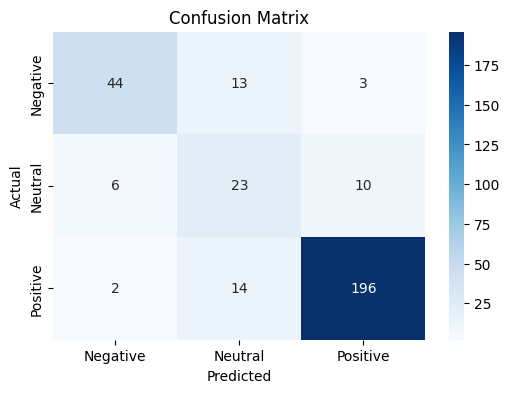

In [26]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

**positive**: most accurate class, very well-learned

**neutral**: model struggles the most, but it's common in language models as neutral language often overlaps with mild praise/criticism

**negative**: moderately accurate

In [27]:
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

test_df['label_text'] = test_df['label'].map(label_map)
test_df['predicted_text'] = test_df['predicted_label'].map(label_map)

test_df[['text', 'label_text', 'predicted_text']].sample(10)

,text,label_text,predicted_text
242,So glad this place opened in the neighborhood....,Positive,Positive
244,Walking around town on a Friday night looking ...,Positive,Neutral
216,Love this place kitchen close at 1 dm and the ...,Positive,Positive
213,"Maybe we got lucky with the server, but the li...",Positive,Neutral
44,I'm from NY and was EXTREMELY excited to see t...,Positive,Positive
236,Came here to get started on happy hour and we ...,Neutral,Neutral
164,Food was okay. I loved the chips before hand m...,Positive,Neutral
77,I ate here with a friend a few weeks back. Qui...,Positive,Positive
40,Cashiers with an attitude. Rude jerks! This pl...,Negative,Negative
145,"Great location, great service, and good food! ...",Positive,Positive


In [28]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

restaurant_dropdown = widgets.Dropdown(
    options=sorted(test_df['name'].unique()),
    description='Restaurant:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

output = widgets.Output()

def on_restaurant_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        selected_restaurant = change['new']
        filtered_df = test_df[test_df['name'] == selected_restaurant]
        avg_sentiment = filtered_df['predicted_label'].mean()
        label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
        rounded = round(avg_sentiment)
        general_rating = label_map.get(rounded, "Unknown")

        with output:
            output.clear_output()
            print(f"\n📊 General Sentiment: {general_rating} (Average score: {round(avg_sentiment, 2)})")
            display(filtered_df[['text', 'predicted_text']].head(5))

restaurant_dropdown.observe(on_restaurant_change)
display(restaurant_dropdown, output)

Dropdown(description='Restaurant:', layout=Layout(width='50%'), options=('4 Seasons Grill Mexican Restaurant',…

Output()

In [29]:
test_df[['name', 'text', 'predicted_text']].to_json("test_data.json", orient="records")

from google.colab import files
files.download("test_data.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [74]:
# best so far
html_code = """
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8" />
  <meta name="viewport" content="width=device-width, initial-scale=1.0"/>
  <title>Spill the Salsa: BERT Sentiment Analysis on Yelp reviews for Mexican restaurants in Philadelphia</title>
  <link href="https://fonts.googleapis.com/css2?family=Amatic+SC:wght@700&family=Quicksand:wght@400;600&display=swap" rel="stylesheet">
  <style>
    body {
      font-family: 'Quicksand', sans-serif;
      margin: 0;
      padding: 40px 20px;
      background: linear-gradient(135deg, #fffbea, #ffe8d6), url('https://www.transparenttextures.com/patterns/purty-wood.png');
      background-size: cover;
      color: #3e2723;
    }

    h1 {
      text-align: center;
      font-size: 2.8rem;
      font-family: 'Amatic SC', cursive;
      color: #d32f2f;
      margin-bottom: 10px;
    }

    h2 {
      text-align: center;
      font-size: 1.2rem;
      color: #6d4c41;
      font-weight: 600;
    }

    label {
      font-weight: 600;
      color: #6d4c41;
    }

    select, input[type="search"], button {
      padding: 12px;
      font-size: 16px;
      margin-top: 10px;
      border: 2px solid #ffa726;
      border-radius: 10px;
      width: 100%;
      max-width: 400px;
      box-shadow: 0 3px 6px rgba(0,0,0,0.1);
      background-color: #fff8e1;
      color: #5d4037;
    }

    select:focus, input[type="search"]:focus, button:hover {
      outline: none;
      border-color: #ef5350;
    }

    .container {
      max-width: 900px;
      margin: auto;
      display: flex;
      justify-content: space-between;
    }

    .left-column {
      width: 65%;
    }

    .right-column {
      width: 30%;
    }

    .card {
      background-color: #fff3e0;
      border-radius: 14px;
      padding: 20px;
      margin-top: 25px;
      box-shadow: 0 6px 10px rgba(0,0,0,0.08);
      border: 2px solid #ff7043;
    }

    .card strong {
      font-weight: 700;
      color: #bf360c;
    }

    table {
      width: 100%;
      margin-top: 15px;
      border-collapse: collapse;
      border-radius: 8px;
      overflow: hidden;
    }

    th, td {
      padding: 12px;
      text-align: left;
      border-bottom: 1px solid #ffe0b2;
    }

    th {
      background-color: #fbc02d;
      color: #4e342e;
      font-weight: 600;
    }

    tr:hover {
      background-color: #fff8e1;
    }

    .pagination {
      margin-top: 15px;
      display: flex;
      justify-content: center;
      gap: 12px;
    }

    .pagination button {
      padding: 8px 14px;
      font-size: 14px;
      border: none;
      border-radius: 8px;
      background-color: #d84315;
      color: white;
      cursor: pointer;
      transition: background 0.3s;
    }

    .pagination button:hover {
      background-color: #bf360c;
    }

    .pagination button:disabled {
      background-color: #ef9a9a;
      cursor: not-allowed;
    }

    .center {
      text-align: center;
      font-size: 1.1rem;
      font-weight: 500;
      margin-top: 10px;
    }

    #pieChart {
      width: 250px;
      height: 250px;
      margin-top: 15px;
      margin-left: auto;
      margin-right: auto;
    }

    @media (max-width: 600px) {
      table, th, td {
        font-size: 14px;
      }

      h1 {
        font-size: 2rem;
      }

      .container {
        flex-direction: column;
      }

      .right-column {
        width: 100%;
        margin-top: 20px;
      }
    }
  </style>
</head>
<body>

  <div class="container">
    <div class="left-column">
      <h1>Spill the Salsa: BERT Sentiment Analysis on Yelp reviews for Mexican restaurants in Philadelphia</h1>
      <h2>By Rani Misra, Kashfia Sharmin, Cheryl Chiu, and Abby Davis</h2>

      <div class="form-group">
        <label for="restaurantDropdown">Select a restaurant:</label>
        <select id="restaurantDropdown">
          <option value="">Loading...</option>
        </select>
      </div>

      <div class="form-group">
        <label for="sentimentDropdown">Filter by sentiment:</label>
        <select id="sentimentDropdown">
          <option value="">All Sentiments</option>
          <option value="Negative">Negative</option>
          <option value="Neutral">Neutral</option>
          <option value="Positive">Positive</option>
        </select>
      </div>

      <div class="form-group">
        <label for="searchBox">Search reviews:</label>
        <input type="search" id="searchBox" placeholder="Search for keywords..." />
      </div>

      <div id="statusMessage" class="center"></div>

      <div id="generalSentiment" class="card center"></div>

      <div class="card">
        <table>
          <thead>
            <tr>
              <th>Review</th>
              <th>Predicted Sentiment</th>
            </tr>
          </thead>
          <tbody id="sentimentText"></tbody>
        </table>
        <div class="pagination">
          <button id="prevBtn">Previous</button>
          <span id="pageIndicator"></span>
          <button id="nextBtn">Next</button>
        </div>
      </div>
    </div>

    <div class="right-column">
      <div class="card">
        <h3 class="center">Sentiment Breakdown</h3>
        <canvas id="pieChart"></canvas>
      </div>
    </div>
  </div>

  <script src="https://cdn.jsdelivr.net/npm/chart.js"></script>
  <script>
  const dropdown = document.getElementById("restaurantDropdown");
  const sentimentDropdown = document.getElementById("sentimentDropdown");
  const searchBox = document.getElementById("searchBox");
  const generalSentiment = document.getElementById("generalSentiment");
  const sentimentText = document.getElementById("sentimentText");
  const statusMessage = document.getElementById("statusMessage");
  const prevBtn = document.getElementById("prevBtn");
  const nextBtn = document.getElementById("nextBtn");
  const pageIndicator = document.getElementById("pageIndicator");

  let allData = [];
  let currentPage = 1;
  const itemsPerPage = 5;
  let currentRestaurantData = [];

  const sentimentMap = {
    "Negative": 0,
    "Neutral": 1,
    "Positive": 2
  };

  const sentimentIcons = {
    "Negative": "🌶️😠",
    "Neutral": "🌮😐",
    "Positive": "🎉😊"
  };

  const ctx = document.getElementById("pieChart").getContext("2d");
  let pieChart;

  statusMessage.innerText = "Loading data...";
  fetch('https://raw.githubusercontent.com/rani-misra/Deep-Learning/main/test_data.json')
    .then(res => res.json())
    .then(data => {
      allData = data;
      const names = [...new Set(data.map(item => item.name))].sort();
      dropdown.innerHTML = "<option value=''>Select a restaurant</option>";
      names.forEach(name => {
        const option = document.createElement("option");
        option.value = name;
        option.textContent = name;
        dropdown.appendChild(option);
      });
      statusMessage.innerText = "";
    })
    .catch(err => {
      console.error(err);
      statusMessage.innerText = "❌ Failed to load data.";
    });

  dropdown.addEventListener("change", () => {
    const selected = dropdown.value;
    if (selected) {
      currentRestaurantData = allData.filter(item => item.name === selected);
      currentPage = 1;

      const counts = { "Negative": 0, "Neutral": 0, "Positive": 0 };
      currentRestaurantData.forEach(item => {
        if (item.predicted_text in counts) {
          counts[item.predicted_text]++;
        }
      });

      const general = Object.entries(counts).sort((a, b) => b[1] - a[1])[0][0];
      generalSentiment.innerHTML = `General Sentiment: <strong>${sentimentIcons[general]} ${general}</strong>`;

      renderPage();
      updatePieChart(counts);
    } else {
      generalSentiment.innerHTML = "";
      sentimentText.innerHTML = "";
      pageIndicator.innerText = "";
    }
  });

  sentimentDropdown.addEventListener("change", () => {
    renderPage();
  });

  searchBox.addEventListener("input", () => {
    renderPage();
  });

  function renderPage() {
    const selectedSentiment = sentimentDropdown.value;
    const searchQuery = searchBox.value.toLowerCase();

    const filteredData = currentRestaurantData.filter(item => {
      const matchesSentiment = selectedSentiment ? item.predicted_text === selectedSentiment : true;
      const matchesSearch = searchQuery ? item.text.toLowerCase().includes(searchQuery) : true;
      return matchesSentiment && matchesSearch;
    });

    const start = (currentPage - 1) * itemsPerPage;
    const end = start + itemsPerPage;
    const pageData = filteredData.slice(start, end);

    sentimentText.innerHTML = pageData.map(item => `
      <tr>
        <td>${item.text}</td>
        <td>${item.predicted_text}</td>
      </tr>
    `).join('');

    const totalPages = Math.ceil(filteredData.length / itemsPerPage);
    pageIndicator.innerText = `Page ${currentPage} of ${totalPages}`;

    prevBtn.disabled = currentPage === 1;
    nextBtn.disabled = currentPage === totalPages;
  }

  function updatePieChart(counts) {
    const totalReviews = counts["Negative"] + counts["Neutral"] + counts["Positive"];
    const chartData = {
      labels: ["Negative", "Neutral", "Positive"],
      datasets: [{
        data: [counts["Negative"], counts["Neutral"], counts["Positive"]],
        backgroundColor: ['#d32f2f', '#fbc02d', '#388e3c'],
        borderColor: ['#bf360c', '#f57c00', '#1b5e20'],
        borderWidth: 1
      }]
    };

    if (pieChart) {
      pieChart.destroy();
    }

    pieChart = new Chart(ctx, {
      type: 'pie',
      data: chartData,
      options: {
        responsive: true,
        plugins: {
          legend: {
            position: 'top',
          },
          tooltip: {
            callbacks: {
              label: function(tooltipItem) {
                const percentage = ((tooltipItem.raw / totalReviews) * 100).toFixed(1);
                return `${tooltipItem.label}: ${percentage}%`;
              }
            }
          }
        }
      }
    });
  }

  prevBtn.addEventListener("click", () => {
    if (currentPage > 1) {
      currentPage--;
      renderPage();
    }
  });

  nextBtn.addEventListener("click", () => {
    const totalPages = Math.ceil(currentRestaurantData.length / itemsPerPage);
    if (currentPage < totalPages) {
      currentPage++;
      renderPage();
    }
  });
  </script>

</body>
</html>

"""

In [75]:
from google.colab import files
with open("/content/sentiment_app.html", "w") as f:
    f.write(html_code)

files.download("/content/sentiment_app.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>